## imports

In [1]:
import numpy as np
from numpy import linalg as l
import scipy.integrate as integrate
import matplotlib.pyplot as plt

## initial state

In [32]:
a = 5
k = 1
y = np.linspace(-a, a, 1001)
y_ = np.linspace(-a, a, 1001)

Y, Y_ = np.meshgrid(y, y_)

step_y = y[1] - y[0]
u = np.tanh(y)
dev2u = - 2 * np.tanh(y) / np.cosh(y) ** 2

min_Y = np.minimum(Y, Y_)
max_Y = np.maximum(Y, Y_)

In [ ]:
zeta_exact = 1 / np.cosh(y)
psi_exact = -2 / np.cosh(y) ** 3

## functions

In [3]:
def count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y):
    green = - (np.exp(- k * max_Y) - np.exp(- k * (2 * a - max_Y))) \
             * (np.exp(k * min_Y) - np.exp(- k * (2 * a + min_Y))) \
             / (1 - np.exp(- 4 * k * a)) / 2 / k
    kernel = np.diag(u) - dev2u * step_y * green
    val, vect = l.eig(kernel)
    return val, vect

In [4]:
def plot_eigen(val, vect, k):
    fig, ax = plt.subplots(figsize=(8, 2))
    
    plt.subplot(1, 2, 1)
    plt.scatter(np.real(val), np.imag(val), s=8, alpha=0.7, label=f'k = {k.round(5)}')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.legend(fontsize=8)

    plt.subplot(1, 2, 2)
    vect = vect.T
    idx_complexval1 = np.imag(val).argmax()
    idx_complexval2 = np.imag(val).argmin()
    plt.plot(vect[idx_complexval1], y, label=f'eigenvector with C={val[idx_complexval1].round(2)}')
    plt.legend()
    
    return plt.show()

In [58]:
def plot_difference(vals, vect, k):
    vect = vect.T
    idx_complexval = np.imag(vals).argmax()
    zeta_vect = vect[idx_complexval]
    psi_vect = zeta_vect * (u + 1e-15 - vals[idx_complexval]) / (dev2u - 1e-15)
    
    fig, ax = plt.subplots(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.plot(zeta_vect, y, label=f'eigenvector with C={vals[idx_complexval].round(2)}')
    plt.plot(zeta_exact, y, label='exact solution for zeta')
    plt.legend()

    plt.subplot(1, 2, 2)
    vect = vect.T
    idx_complexval = np.imag(vals).argmax()
    plt.plot(psi_vect, y, label=f'psi with C={vals[idx_complexval].round(2)}')
    plt.plot(psi_exact, y, label='exact solution for psi')
    plt.legend()

## stability criteria research

In [5]:
imag_vals = []
for k in np.linspace(0.99, 1., 50):
    vals, vect = count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y)
    imag_vals.append((k, np.imag(vals).max()))
    #plot_eigen(vals, vect, k)

In [6]:
imag_vals = np.array(imag_vals)
k_crit = imag_vals.T[0, imag_vals.T[1].argmin()]

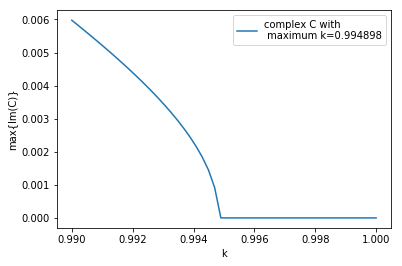

In [7]:
plt.plot(imag_vals.T[0], imag_vals.T[1], label=f'complex C with \n maximum k={k_crit.round(6)}')
plt.xlabel('k')
plt.ylabel('max{Im(C)}')
plt.legend()

## eigenvectors and analytical solution

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


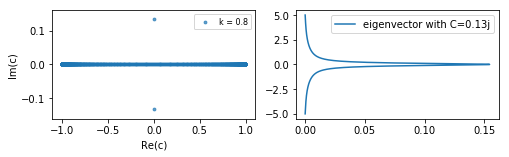

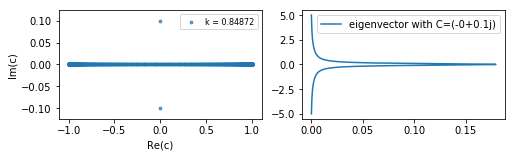

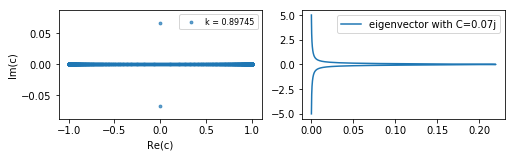

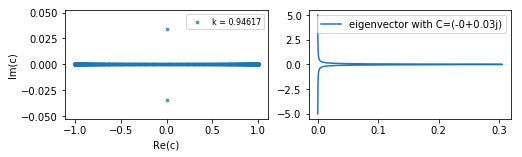

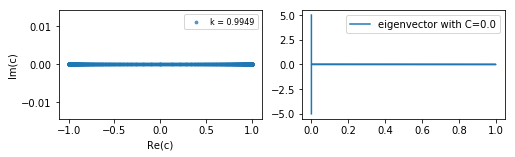

In [8]:
for k in np.linspace(0.8, k_crit, 5):
    vals, vect = count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y)
    plot_eigen(vals, vect, k)

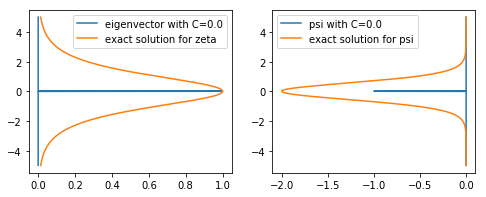

In [59]:
vals, vect = count_eigen(k_crit, a, max_Y, u, min_Y, dev2u, step_y)
plot_difference(vals, vect, k_crit)

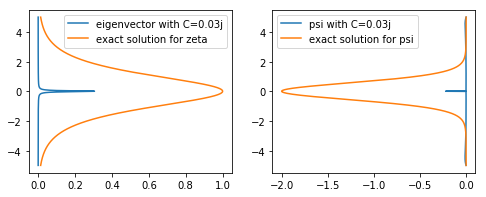

In [65]:
vals, vect = count_eigen(0.94617, a, max_Y, u, min_Y, dev2u, step_y)
plot_difference(vals, vect, 0.94617)